# Ridge Regression Analysis - WIN PREDICTION

## IMPORTING DATA & LIBRARIES

In [1]:
# nba data
from nba_api.stats.endpoints import teamestimatedmetrics

# data manipulation/visualization packages
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import json

# scikit
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier,DummyRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer


In [2]:
# initialize empty df
team_data = pd.DataFrame()

# get data for all teams years 1980-2023
for year in range(1980, 2024):
    season = f"{year}-{str(year + 1)[-2:]}"  
    team_stats = teamestimatedmetrics.TeamEstimatedMetrics(season=[season]).get_data_frames()[0][:40]
    team_data = pd.concat([team_data, team_stats])

In [3]:
team_data

,TEAM_NAME,TEAM_ID,GP,W,L,W_PCT,MIN,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,...,MIN_RANK,E_OFF_RATING_RANK,E_DEF_RATING_RANK,E_NET_RATING_RANK,E_AST_RATIO_RANK,E_OREB_PCT_RANK,E_DREB_PCT_RANK,E_REB_PCT_RANK,E_TM_TOV_PCT_RANK,E_PACE_RANK
0,Boston Celtics,1610612738,82,15,67,0.183,3981.0,100.8,108.8,-8.0,...,5,26,27,27,20,21,18,28,8,1
1,Philadelphia 76ers,1610612755,82,22,60,0.268,3956.0,101.4,108.4,-6.9,...,25,22,25,24,29,3,28,17,27,2
2,Phoenix Suns,1610612756,82,40,42,0.488,3971.0,106.7,105.5,1.2,...,7,6,18,14,4,29,11,26,3,3
3,New Jersey Nets,1610612751,82,26,56,0.317,3956.0,101.4,106.5,-5.1,...,22,23,23,23,27,1,16,5,9,4
4,Denver Nuggets,1610612743,82,21,61,0.256,3986.0,101.2,108.2,-7.0,...,1,25,24,25,11,25,13,20,18,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Toronto Raptors,1610612761,82,41,41,0.500,3961.0,112.2,111.4,0.8,...,18,16,14,14,25,3,10,13,1,26
26,Philadelphia 76ers,1610612755,82,54,28,0.659,3976.0,115.5,110.2,5.2,...,5,3,8,3,9,26,8,19,16,27
27,Dallas Mavericks,1610612742,82,38,44,0.463,3986.0,114.3,114.0,0.3,...,3,6,24,16,24,30,21,30,2,28
28,Miami Heat,1610612748,82,44,38,0.537,3961.0,110.4,110.6,-0.2,...,18,25,9,21,21,21,5,22,13,29


## EDA

In [4]:
team_data['TEAM_NAME'].value_counts()

Boston Celtics                       27
New York Knicks                      27
Cleveland Cavaliers                  27
Detroit Pistons                      27
Atlanta Hawks                        27
San Antonio Spurs                    27
Miami Heat                           27
Orlando Magic                        27
Indiana Pacers                       27
Philadelphia 76ers                   27
Milwaukee Bucks                      27
Utah Jazz                            27
Chicago Bulls                        27
Dallas Mavericks                     27
Toronto Raptors                      27
Los Angeles Lakers                   27
Phoenix Suns                         27
Golden State Warriors                27
Houston Rockets                      27
Denver Nuggets                       27
Sacramento Kings                     27
Portland Trail Blazers               27
Minnesota Timberwolves               27
Washington Wizards                   26
Memphis Grizzlies                    22


The difference in value counts in team names stems from name changes that have occurred. Eg: Vancouver Grizzlies & Memphis Grizzlies are the same franchise, just having undergone a name change.

In [5]:
# get rid of columns that don't contribute to predicting number of wins/are redundant
team_data.columns

Index(['TEAM_NAME', 'TEAM_ID', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'E_OFF_RATING',
       'E_DEF_RATING', 'E_NET_RATING', 'E_PACE', 'E_AST_RATIO', 'E_OREB_PCT',
       'E_DREB_PCT', 'E_REB_PCT', 'E_TM_TOV_PCT', 'GP_RANK', 'W_RANK',
       'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'E_OFF_RATING_RANK',
       'E_DEF_RATING_RANK', 'E_NET_RATING_RANK', 'E_AST_RATIO_RANK',
       'E_OREB_PCT_RANK', 'E_DREB_PCT_RANK', 'E_REB_PCT_RANK',
       'E_TM_TOV_PCT_RANK', 'E_PACE_RANK'],
      dtype='object')

In [6]:
team_data_final=team_data.drop(columns=['TEAM_NAME','L','TEAM_ID', 'MIN','GP','W_PCT','GP_RANK','W_RANK','L_RANK','W_PCT_RANK', 'MIN_RANK','E_OFF_RATING_RANK',
       'E_DEF_RATING_RANK', 'E_NET_RATING_RANK', 'E_AST_RATIO_RANK',
       'E_OREB_PCT_RANK', 'E_DREB_PCT_RANK', 'E_REB_PCT_RANK',
       'E_TM_TOV_PCT_RANK', 'E_PACE_RANK'])
team_data_final.columns = map(str.lower, team_data_final.columns)
team_data_final.columns

Index(['w', 'e_off_rating', 'e_def_rating', 'e_net_rating', 'e_pace',
       'e_ast_ratio', 'e_oreb_pct', 'e_dreb_pct', 'e_reb_pct', 'e_tm_tov_pct'],
      dtype='object')

## PREPROCESSING

In [63]:
# subset Xs and Y
X = team_data_final.drop(columns = ['w'])
Y = team_data_final['w']
X.head()

,e_off_rating,e_def_rating,e_net_rating,e_pace,e_ast_ratio,e_oreb_pct,e_dreb_pct,e_reb_pct,e_tm_tov_pct
0,100.8,108.8,-8.0,98.3,16.1,0.294,0.685,0.475,0.164
1,101.4,108.4,-6.9,98.1,15.2,0.341,0.665,0.499,0.177
2,106.7,105.5,1.2,95.8,18.9,0.271,0.694,0.484,0.149
3,101.4,106.5,-5.1,95.3,15.5,0.364,0.690,0.518,0.164
4,101.2,108.2,-7.0,95.2,17.4,0.288,0.693,0.493,0.171


In [8]:
# split data so that there is 30% set aside for test
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=22)

In [9]:
# view some data
X_train.head()
numeric_features = X.columns.tolist()
numeric_features

['e_off_rating',
 'e_def_rating',
 'e_net_rating',
 'e_pace',
 'e_ast_ratio',
 'e_oreb_pct',
 'e_dreb_pct',
 'e_reb_pct',
 'e_tm_tov_pct']

## MODEL CREATION

## DummyRegressor

In [65]:
dummy = DummyRegressor()
pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=5, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.003023,0.000946,-0.001503,0.0
1,0.001995,0.002401,-0.017266,0.0
2,0.001999,0.000996,-0.008184,0.0
3,0.001995,0.000994,-0.008013,0.0
4,0.001995,0.000997,-0.007314,0.0


## Ridge Regression

In [64]:
# create Ridge pipeline
RidgePipe = make_pipeline(StandardScaler(),Ridge())
scores = cross_validate(RidgePipe, X_train, y_train, cv= 5,return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.043768,0.003384,0.903936,0.841373
1,0.006331,0.002917,0.808693,0.867027
2,0.007517,0.001995,0.833441,0.862168
3,0.005147,0.002006,0.866292,0.855378
4,0.004984,0.001994,0.831181,0.863251


## Optimizing Ridge ALPHA parameter

In [66]:
scores_dict = {
    "alpha": 10.0 ** np.arange(-3, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for alpha in scores_dict["alpha"]:
    pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    scores = cross_validate(pipe_ridge, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)

In [67]:
results_df

,alpha,mean_train_scores,mean_cv_scores
0,0.001,0.858264,0.848814
1,0.010,0.858207,0.848832
2,0.100,0.857948,0.848697
3,1.000,0.857839,0.848708
4,10.000,0.857601,0.848967
5,100.000,0.844989,0.837357
6,1000.000,0.618494,0.610681
7,10000.000,0.143609,0.135252
8,100000.000,0.016387,0.007943


In [68]:
# view fundamental tradeoff of increasing/decreasing alpha 
alphas = 10.0 ** np.arange(-5, 5, 1)
train_scores = []
cv_scores = []
for alpha in alphas:
    lr = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    results = cross_validate(lr, X_train, y_train, return_train_score=True)
    train_scores.append(np.mean(results["train_score"]))
    cv_scores.append(np.mean(results["test_score"]))

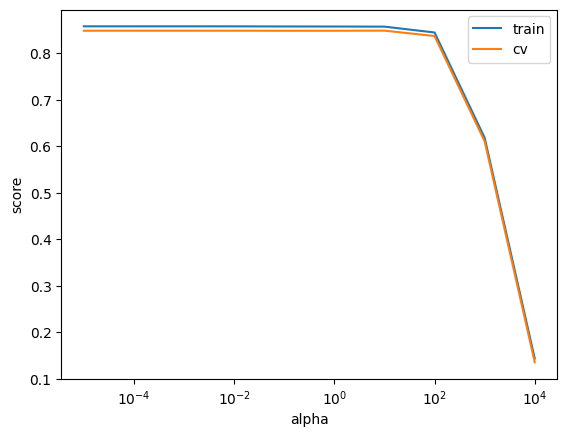

In [69]:
plt.semilogx(alphas, train_scores, label="train")
plt.semilogx(alphas, cv_scores, label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score");

In [70]:
# get best alpha
best_alpha = alphas[np.argmax(cv_scores)]
best_alpha

10.0

## Coefficients & Intercept

In [71]:
pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
pipe_ridge.fit(X_train, y_train)
coeffs = pipe_ridge.named_steps["ridge"].coef_

In [72]:
# coefficients
pd.DataFrame(data=coeffs, index=X.columns, columns=["Coefficients"])

,Coefficients
e_off_rating,4.039701
e_def_rating,-3.532761
e_net_rating,6.644601
e_pace,-0.363932
e_ast_ratio,0.330375
e_oreb_pct,-0.318216
e_dreb_pct,-0.508959
e_reb_pct,0.959363
e_tm_tov_pct,-0.807683


In [73]:
# intercept
pipe_ridge.named_steps["ridge"].intercept_

39.49376114081998

## Create Data to Predict With

In [75]:
# get column names
column_names = X_train.columns.tolist()

In [82]:
# get min/max of transformed data
X_train_range = X_train.describe()
X_train_endp = X_train_range.drop(['count', 'mean', 'std','25%','50%','75%'])
X_train_endp

,e_off_rating,e_def_rating,e_net_rating,e_pace,e_ast_ratio,e_oreb_pct,e_dreb_pct,e_reb_pct,e_tm_tov_pct
min,89.8,91.6,-15.5,86.9,13.0,0.180,0.629,0.444,0.110
max,117.0,117.7,11.8,106.4,20.5,0.367,0.812,0.547,0.204


In [84]:
# turn min row to list
X_train_min = X_train_endp.iloc[0]
X_train_min_list = X_train_min.tolist()
X_train_min_list

[89.8, 91.6, -15.5, 86.9, 13.0, 0.18, 0.629, 0.444, 0.11]

In [85]:
# turn max row into list
X_train_max = X_train_endp.iloc[1]
X_train_max_list = X_train_max.tolist()
X_train_max_list

[117.0, 117.7, 11.8, 106.4, 20.5, 0.367, 0.812, 0.547, 0.204]

In [107]:
# create function to generate random values for prediction
def generate_random_array(num_rows, num_columns, min_values, max_values):
    if len(min_values) != num_columns or len(max_values) != num_columns:
        raise ValueError("min_values and max_values must have the same length as num_columns")
    
    random_array = np.random.uniform(low=min_values, high=max_values, size=(num_rows, num_columns))
    return random_array

num_rows = 1  # Number of rows in the array
num_columns = 9  # Number of columns in the array

random_array = generate_random_array(num_rows, num_columns, X_train_min_list, X_train_max_list)
random_array = random_array.tolist()
random_array

[[96.60772323259296,
  102.85835266744745,
  2.529951265845348,
  104.9907369951403,
  20.26855026837754,
  0.3398256827232771,
  0.7055603456840243,
  0.4778671275553001,
  0.1548020870641309]]

## PREDICTION

In [108]:
pipe_ridge.predict(random_array)

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([35.41719453])